# Migration Engagement - Discovery Tool
### Work in Progress


To Do:\
https://docs.google.com/document/d/10Q6_sXdB9LcRJmujnIHDKMFLMBvoq-4lj5KgHTXWohI/edit#
* Use github credentials within the application to authorize itself
* Identify all repositories that this user has access to read from
* Search each repository for gradle.build or pom.xml
* Come up with a scheme so that each of the build files identified is downloaded locally, but in a way that we can easily map it to its original github repository

Improvements:
* Store necessary variables externally (local_token_path, local_output_path, etc.)
* Store list of regular expressions externally ('build.gradle', 'pom.xml', etc.)
* Currently dealing with hourly request limits (5000) by sleeping and retrying in the next hour
  * Is there a way to increase the request limit?
  
Handy links:

* Enfuse Github Repos List: https://github.com/orgs/enfuse/repositories?language=&page=2&q=&sort=name&type=all
* API Docs: https://github.com/PyGithub/PyGithub
* API Docs Exceptions: https://pygithub.readthedocs.io/en/latest/utilities.html#module-github.GithubException


## Generating a token

Go to your profile 'Settings', then scroll to the very bottom of the menu on the left to 'Developer settings'.\
Choose 'Personal access tokens' and then 'Generate new token'.\
The user password will be necessary at this point. Once, you enter the password you can create the token.\
Fill out the Note section and choose the scopes in the 'Select scope' section.  Then, scroll all the way down and 'Generate token'.\
Make sure to save the token in an external file immediately.  It is a better idea to fetch the token than to hard-code it.\

See images below...
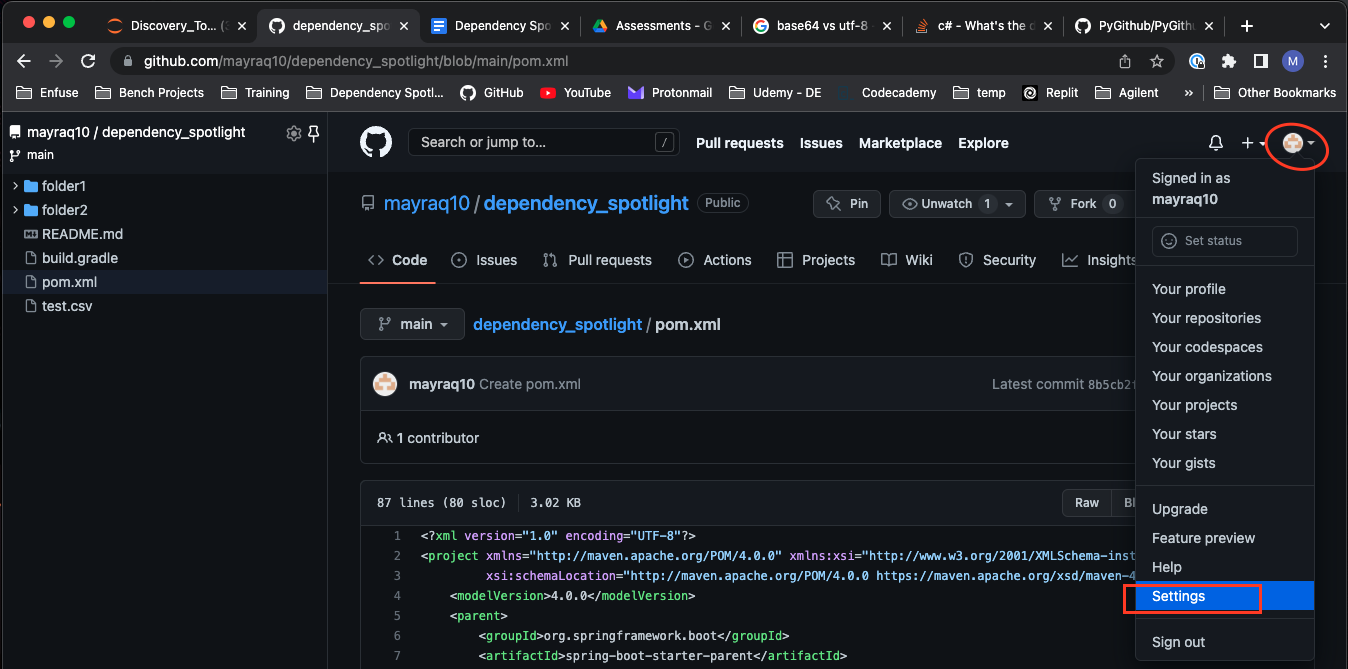
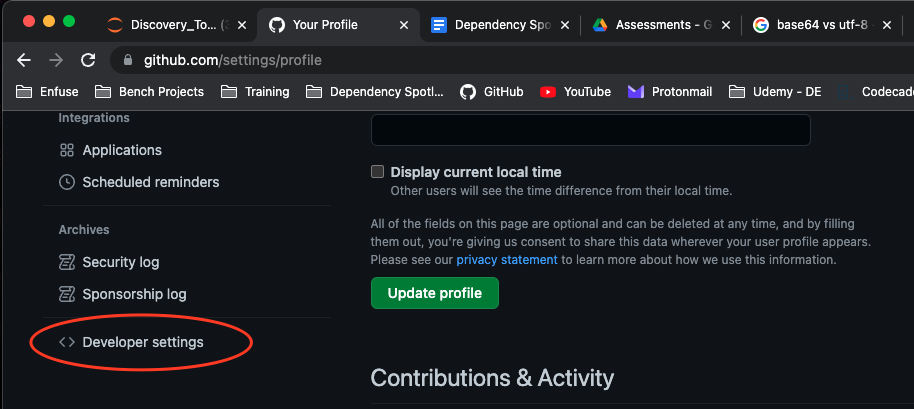
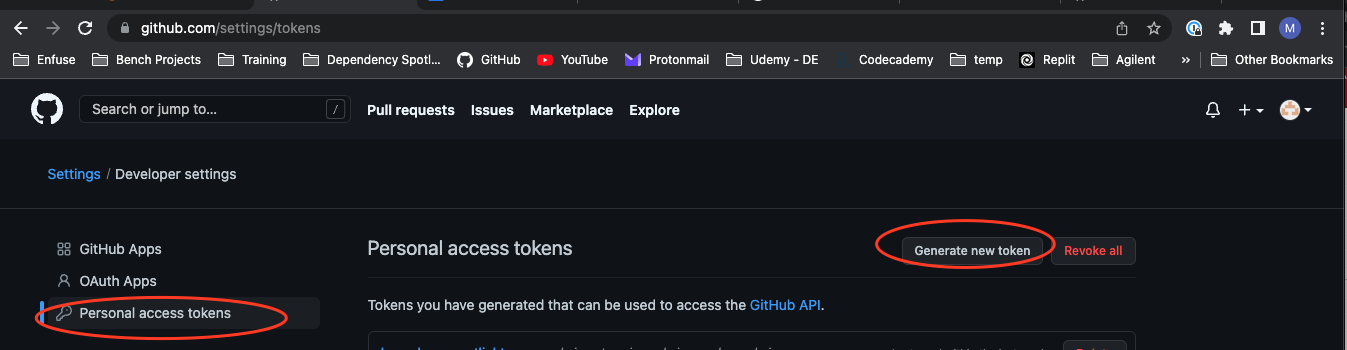
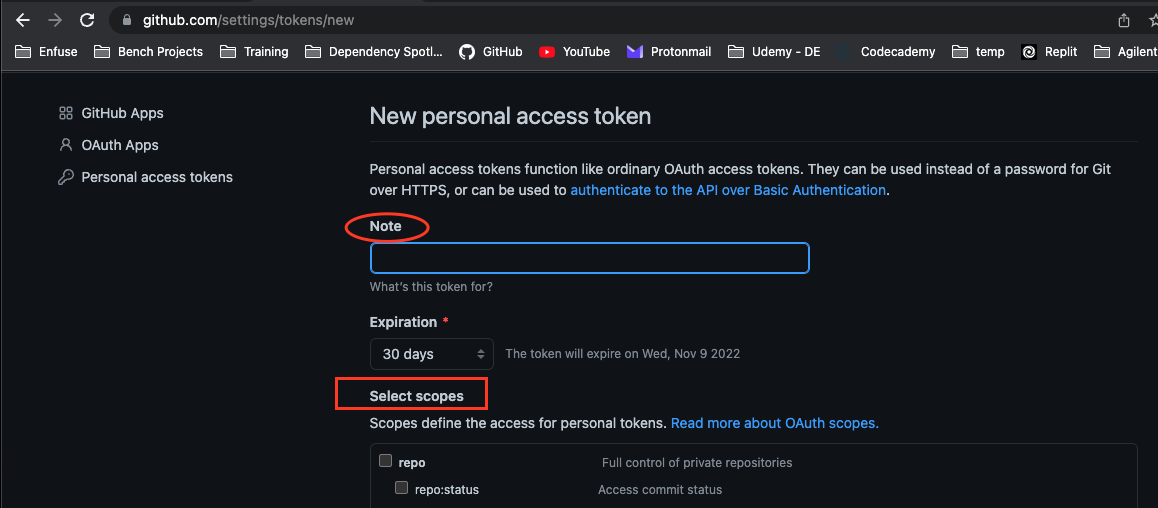


## Exploratory Section 
- Complete code in last cell below

### Set Up

In [ ]:
!pip install PyGithub

In [ ]:
from github import Github
import os
import re
import urllib
import base64
import logging

### Connect to Github

In [ ]:
## add a markdown cell showing how to create a token
with open("/Users/MayraQ/dev/dependency_spotlight/access_token.txt", 'r') as f:
    token = f.readline()
    
g = Github(token)

In [ ]:
g.get_rate_limit()

### Explore Repositories

In [ ]:
# Show all accessible repos 
for repo in g.get_user().get_repos():
    print(repo.full_name)

In [ ]:
# Just looking at one repo
repo = g.get_repo("mayraq10/dependency_spotlight")

content = repo.get_contents("")

# This only goes one level deep
for content_file in content:
    print(content_file)

#### Get the file paths we need

In [ ]:
# Recursive way of walking every directory

repo = g.get_repo("mayraq10/dependency_spotlight")
contents = repo.get_contents("")
regex_list = [re.compile('build.gradle'), re.compile('pom.xml')]

while contents:
    file_content = contents.pop(0)
    if file_content.type == "dir":
        contents.extend(repo.get_contents(file_content.path))
    else:
        for regex in regex_list:
            match = re.findall(regex, file_content.path)
            if len(match) != 0:
                print(file_content.path)

#### Get content of a file and write to a local copy

In [ ]:
# Get content

# import urllib
# import base64

def github_file_to_bytes(repo, path, git_token, branch="main"):
    g = Github(git_token)
    repo = g.get_repo(repo)
    content_encoded = repo.get_contents(urllib.parse.quote(path), ref=branch).content
    content = base64.b64decode(content_encoded)
    return content

In [ ]:
content = github_file_to_bytes(repo="mayraq10/dependency_spotlight", path="folder2/folder2a/pom.xml", git_token=token, branch="main")
# content = github_file_to_bytes(repo="mayraq10/dependency_spotlight", path="pom.xml", git_token=token, branch="main")

In [ ]:
content


In [ ]:
content.decode('UTF-8')

In [ ]:
# Write to a file

def write_to_file(destination, filename, content):
    f = open(destination + filename , 'w')
    f.write(str(content))
    f.close()
    

In [ ]:
destination = '/Users/MayraQ/dev/dependency_spotlight/copied_files/'

filename = 'folder2_folder2a_pom.xml'

write_to_file(destination, filename,content)

In [ ]:
# filename = 'pom.xml'
# write_to_file(destination, filename,content)

In [ ]:
repo = g.get_repo("enfuse/crate")

try:
    branch = repo.get_branch(branch="main")
except:
    branch = repo.get_branch(branch="master")

branch

# Put it all together

In [ ]:
#### Set or fetch necessary paths
local_token_path = "/Users/MayraQ/dev/dependency_spotlight/access_token.txt"
local_output_path = '/Users/MayraQ/dev/dependency_spotlight/copied_files/' # If folder DNE, it's created

#### Connect to GH
with open(local_token_path, 'r') as f:
    token = f.readline()
    
g = Github(token , retry=1 , timeout=5) # haven't had to retry yet, so keeping the count low for now

#### Go through all accessible repos 
for repository in g.get_user().get_repos():
    
    repo_name = repository.full_name
    repo = g.get_repo(repo_name)
    contents = repo.get_contents("")
    
    #### What files do we want?
    regex_list = [re.compile('build.gradle'), re.compile('pom.xml')]  
    
    
    #### Get all file paths
    paths_list = []
    
    while contents: 
        
        file_content = contents.pop(0)
        if file_content.type == "dir":
            contents.extend(repo.get_contents(file_content.path))
        else:
            for regex in regex_list:
                match = re.findall(regex, file_content.path)
                if len(match) != 0:
                    paths_list.append(file_content.path)
                    
    #### Create folders and copy files
    if len(paths_list) != 0:
        
        for path in paths_list:
            
            destination = local_output_path + repo_name + '/' + path
            os.makedirs(os.path.dirname(destination), exist_ok=True)
            
            content_encoded = repo.get_contents(urllib.parse.quote(path)).content
            content = base64.b64decode(content_encoded).decode('utf-8')
            
            with open(destination , 'w') as f:
                f.write(content)
   
    

### Let's add logging 
* Runs through one repo only - hardcoded

In [5]:
from github import Github
import os
import re
import urllib
import base64
import logging
# ---- new imports
from github import RateLimitExceededException, BadCredentialsException, BadAttributeException, \
    GithubException, UnknownObjectException, BadUserAgentException
import requests # to handle some exceptions not included in the github lib
import time 


#### --- Logging configuration -----------------------------------------------------------------------------

# to console
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s")

# to file
logger = logging.getLogger(__name__) # module name, in case we break up the code
handler = logging.FileHandler('discovery.log')  #TODO: make this more dynamic, include dates or whatever
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s: %(message)s')
handler.setFormatter(formatter)

logger.addHandler(handler)
logger.setLevel(20)  # 0,10,20,30,40,50 (notset, debug, info, warning, error, critical)

# logger.info('Test the custom logger.')
#### ------------------------------------------------------------------------------------------------------

#### Set or fetch necessary paths
local_token_path = "/Users/MayraQ/dev/dependency_spotlight/access_token.txt"
local_output_path = '/Users/MayraQ/dev/dependency_spotlight/copied_files/' # If folder DNE, it's created

#### Connect to GH
with open(local_token_path, 'r') as f:
    token = f.readline()

g = Github(token , retry=1 , timeout=5) # haven't had to retry yet, so keeping the count low for now

logger.info('Connected to GH')
logger.info(g.get_rate_limit())

#### Go through all accessible repos 
# for repository in g.get_user().get_repos():


repo_name = 'mayraq10/dependency_spotlight' #repository.full_name

repo = g.get_repo(repo_name)
contents = repo.get_contents("")

#### What files do we want?
regex_list = [re.compile('build.gradle'), re.compile('pom.xml')]  


#### Get all file paths
paths_list = []



while contents: 
    
    file_content = contents.pop(0)
    if file_content.type == "dir":
        contents.extend(repo.get_contents(file_content.path))
    else:
        for regex in regex_list:
            match = re.findall(regex, file_content.path)
            if len(match) != 0:
                paths_list.append(file_content.path)
                
logger.info('Content paths extracted.')
logger.info(g.get_rate_limit())
                
#### Create folders and copy files
if len(paths_list) != 0:
    
    for path in paths_list:
        
        destination = local_output_path + repo_name + '/' + path
        os.makedirs(os.path.dirname(destination), exist_ok=True)
        
        content_encoded = repo.get_contents(urllib.parse.quote(path)).content
        content = base64.b64decode(content_encoded).decode('utf-8')
        
        with open(destination , 'w') as f:
            f.write(content)
            
    logger.info('Contents extracted.')
    logger.info(g.get_rate_limit())
    
    
   
logger.info('Process completed.')


2022-10-13 17:54:52,826 - INFO: Connected to GH
2022-10-13 17:54:53,057 - INFO: RateLimit(core=Rate(reset=2022-10-13 22:54:53, remaining=5000, limit=5000))
2022-10-13 17:54:53,818 - INFO: Content paths extracted.
2022-10-13 17:54:53,913 - INFO: RateLimit(core=Rate(reset=2022-10-13 22:54:53, remaining=4993, limit=5000))
2022-10-13 17:54:54,541 - INFO: Contents extracted.
2022-10-13 17:54:54,629 - INFO: RateLimit(core=Rate(reset=2022-10-13 22:54:53, remaining=4988, limit=5000))
2022-10-13 17:54:54,631 - INFO: Process completed.


### Complete code
* loops through all repos
* with logging
* with exception handling

In [ ]:
#!pip install PyGithub
from github import Github
import os
import re
import urllib
import base64
import logging
from github import RateLimitExceededException, BadCredentialsException, BadAttributeException, \
    GithubException, UnknownObjectException, BadUserAgentException
import requests # to handle some exceptions not included in the github lib
import time 

#### --- Logging configuration -----------------------------------------------------------------------------

# to console
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s")

# to file
logger = logging.getLogger(__name__) # module name, in case we break up the code
handler = logging.FileHandler('discovery.log')  #TODO: make this more dynamic, include dates or whatever
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s: %(message)s')
handler.setFormatter(formatter)

logger.addHandler(handler)
logger.setLevel(20)  # 0,10,20,30,40,50 (notset, debug, info, warning, error, critical)

#### ------------------------------------------------------------------------------------------------------

#### Set or fetch necessary paths
local_token_path = "/Users/MayraQ/dev/dependency_spotlight/access_token.txt"
local_output_path = '/Users/MayraQ/dev/dependency_spotlight/copied_files/' # If folder DNE, it's created

#### Connect to GH
with open(local_token_path, 'r') as f:
    token = f.readline()

while True:
    try:
        g = Github(token , retry=1 , timeout=5) # haven't had to retry yet, so keeping the count low for now
        
    #TODO: print or log exceptions?
    except BadCredentialsException as e:
        print(e.status)
        print('Bad credentials exception')
        break
    except requests.exceptions.ConnectionError as e:
        print('Retries limit exceeded')
        print(str(e))
        time.sleep(10)
        continue
    except requests.exceptions.Timeout as e:
        print(str(e))
        print('Time out exception')
        time.sleep(10)
        continue 
    else:
        break

logger.info('Connected to GH')
logger.info(g.get_rate_limit())


#### Go through all accessible repos 
for repository in g.get_user().get_repos():
    
    logger.info(g.get_rate_limit())
    
    while True:
        try:
            repo_name = repository.full_name
            repo = g.get_repo(repo_name)
            contents = repo.get_contents("")
            
            logger.info(f'----- Processing repo ----- :  {repo_name}')

            #### What files do we want?
            regex_list = [re.compile('build.gradle'), re.compile('pom.xml')]  

            #### Get all file paths
            paths_list = []

            while contents: 
                file_content = contents.pop(0)
                if file_content.type == "dir":
                    contents.extend(repo.get_contents(file_content.path))
                else:
                    for regex in regex_list:
                        match = re.findall(regex, file_content.path)
                        if len(match) != 0:
                            paths_list.append(file_content.path)
                
            logger.info('Search for build files complete')
                
            #### Create folders and copy files
            if len(paths_list) != 0:
                for path in paths_list:
        
                    destination = local_output_path + repo_name + '/' + path
                    os.makedirs(os.path.dirname(destination), exist_ok=True)
        
                    content_encoded = repo.get_contents(urllib.parse.quote(path)).content
                    content = base64.b64decode(content_encoded).decode('utf-8')
        
                    with open(destination , 'w') as f:
                        f.write(content)
            
                logger.info('Contents extracted')
                logger.info(g.get_rate_limit())
            else:
                logger.info('No build files found for this repo')
                logger.info(g.get_rate_limit())
        
        #TODO: print or log exceptions?
        except RateLimitExceededException as e:
            print(e.status)
            print('Rate limit exceeded')
            time.sleep(300)
            continue
        except UnknownObjectException as e:
            print(e.status)
            print('Unknown object exception')
            break
        except GithubException as e:
            print(e.status)
            print('General exception')
            break
        break
    
    
   
logger.info('Process completed.')


2022-10-13 18:37:32,622 - INFO: Connected to GH
2022-10-13 18:37:32,845 - INFO: RateLimit(core=Rate(reset=2022-10-13 22:54:53, remaining=663, limit=5000))
2022-10-13 18:37:33,870 - INFO: RateLimit(core=Rate(reset=2022-10-13 22:54:53, remaining=662, limit=5000))
2022-10-13 18:37:34,181 - INFO: ----- Processing repo ----- :  enfuse/akka-scala-example
2022-10-13 18:37:36,019 - INFO: Search for build files complete
2022-10-13 18:37:36,022 - INFO: No build files found for this repo
2022-10-13 18:37:36,117 - INFO: RateLimit(core=Rate(reset=2022-10-13 22:54:53, remaining=647, limit=5000))
2022-10-13 18:37:36,211 - INFO: RateLimit(core=Rate(reset=2022-10-13 22:54:53, remaining=647, limit=5000))
2022-10-13 18:37:36,493 - INFO: ----- Processing repo ----- :  enfuse/asae-assessment
2022-10-13 18:37:36,495 - INFO: Search for build files complete
2022-10-13 18:37:36,497 - INFO: No build files found for this repo
2022-10-13 18:37:36,588 - INFO: RateLimit(core=Rate(reset=2022-10-13 22:54:53, remainin

403
Rate limit exceeded
403
Rate limit exceeded


In [7]:
g.get_rate_limit()

RateLimit(core=Rate(reset=2022-10-13 22:54:53, remaining=663, limit=5000))